In [1]:
# Neural network stuff
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, Flatten, MaxPooling2D, GlobalAveragePooling1D
from keras import regularizers
# Non-neural network models and data preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge, LinearRegression, Lasso
from sklearn.metrics import r2_score as r2
from sklearn.datasets import fetch_olivetti_faces
# Numerical computation and visualization
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


# I. Regularization

In the last lab, we observed that every neural network encodes a non-linear function. We also noted the following:

> ***Neural networks are universal approximators.*** That is, *for any continuous function $f$ on a closed (D-dimensional) interval, we can find  a single hidden layer MLP with a sufficiently large number of hidden nodes that approximates $f$ within some pre-defined measure of 'satisfaction'.*

But unlike other regression models (for example, polynomial regression without cross terms), the number of parameters in deep networks can grow very quickly. Thus, when the number of data points is small the problem of learning an optimal set of weights in not well-defined. Furthermore, we very quickly run into the issue of overfitting to the training data.

How can we generalize techniques for handling potential pathologies of regression or classification problems (again from CS109A and the first half of CS109B) to MLP models?

Let's denote the weights of an MLP collectively by $\mathbf{w}$. Recall from last lab that each MLP represents a function $f(\mathbf{w}, \mathbf{x})$. When we train an MLP by learning $\mathbf{w}$ to minimize mean square error (MSE), we obtain the so-called ordinary least square solution 
$$
\mathbf{w}_{\mathrm{OLS}} = \mathrm{argmin}_{\mathbf{w}} \sum_{n=1}^N (y_n - f(\mathbf{w}, \mathbf{x_n}))^2
$$
Recall from CS109A that one way of reducing model sensitivity to noise in the training data (or, to reduce overfitting) is to apply a regularization term to the objective function, that is, we solve the following optimization problem for example, if we want to penalize the norm of the weight vector
$$
\mathbf{w}_{\mathrm{Ridge}} = \mathrm{argmin}_{\mathbf{w}} \sum_{n=1}^N (y_n - f(\mathbf{w}, \mathbf{x_n}))^2 + \lambda \| \mathbf{w}\|^2_2.
$$
Recall from early this semester that the ordinary least square solution is also the maximum likelihood solution, assuming Gaussian noise (with zero mean)
$$
\mathbf{w}_{\mathrm{OLS}} = \mathbf{w}_{\mathrm{MLE}} = \mathrm{argmax}_{\mathbf{w}} \prod_{n=1}^N \mathcal{N}(y_n| f(\mathbf{w}, \mathbf{x_n}), \sigma).
$$
In this probabilistic context, often, regularization can be interpreted as imposing priors on the weights, and regularized optimization can be interpreted as computing MAP estimates
$$
\mathbf{w}_{\mathrm{Ridge}} = \mathbf{w}_{\mathrm{MAP}} = \mathrm{argmax}_{\mathbf{w}} \mathcal{N}(\mathbf{w}| 0, \Sigma)\prod_{n=1}^N \mathcal{N}(y_n| f(\mathbf{w}, \mathbf{x}), \sigma).
$$
Both regularization and Bayesian inference generalizes to the context of neural networks (i.e. when $f$ is represented by say an MLP).

In this section, we experiment with three ways of regularizing neural networks and compare them to the results of regularized polynomial regression.

In [2]:
# set the number of samples to take for each toy dataset
n_samples = 100
# set the proportion of toy data to hold out for testing
test_size = 0.4
# set observation noise level
sigma = 2.0
# set the random seed to make the experiment reproducible 
random_seed = 1
np.random.seed(random_seed)

In [3]:
# define a function
f = lambda x: 5 * np.sin(np.sqrt(x))**2 + x**(2/3)
# choose some points from the function - this is our toy dataset 
X = np.random.permutation(np.linspace(0, 50, n_samples))
# add some noise to the funciton values
Y = f(X) + np.random.normal(0, sigma, size=len(X))
# create training and testing data from this set of points
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size)

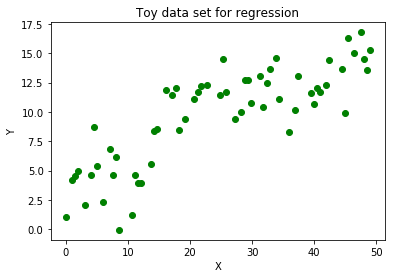

In [4]:
# plot the toy data
fig, ax = plt.subplots()
ax.scatter(X_train, Y_train, color='green')
ax.legend()
ax.set(xlabel='X', ylabel='Y', title='Toy data set for regression')
plt.show()

## A. Overfitting: as we knew it from CS109A

Let's fit a degree 300 polynomial to our data, as you can already imagine, the high degree is over-kill and will lead to overfitting.

In [5]:
# degree of the polynomial model
degree = 300
# add polynomial features to the data and fit a ridge regression model
simple_model = make_pipeline(MinMaxScaler((0, 0.5)), PolynomialFeatures(degree), LinearRegression())
simple_model.fit(X_train.reshape((X_train.shape[0], 1)), Y_train)

Pipeline(memory=None,
     steps=[('minmaxscaler', MinMaxScaler(copy=True, feature_range=(0, 0.5))), ('polynomialfeatures', PolynomialFeatures(degree=300, include_bias=True, interaction_only=False)), ('linearregression', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))])

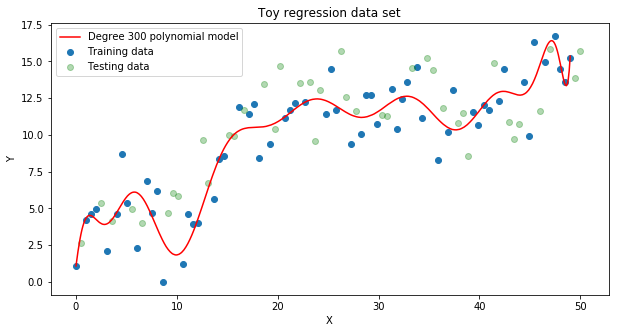

In [6]:
# use our model to predict in the range we want
X_range = np.linspace(0, 49, 500).reshape((500, 1))
y_pred = simple_model.predict(X_range)

# we plot the polynomial model against the data
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.scatter(X_train, Y_train, label='Training data')
ax.scatter(X_test, Y_test, color='g', alpha=0.3, label='Testing data')
ax.plot(X_range, y_pred, color='r', label='Degree ' + str(degree) + ' polynomial model')
ax.legend(loc='best')
ax.set(xlabel='X', ylabel='Y', title='Toy regression data set')
plt.show()

In [7]:
# evaluate the model
print('Train R2:', simple_model.score(X_train.reshape((X_train.shape[0], 1)), Y_train))
print('Test R2:', r2(Y_test, simple_model.predict(X_test.reshape((X_test.shape[0], 1)))))

Train R2: 0.871684020225
Test R2: -7.72695349775


## B. Regularization: as we knew it from CS109A

In CS109A, we've seen two ways of regularizing (restricting the possible set of weights we can consider so to prevent overfitting). Both ways involve adding a term to the loss function penalizing some undesirable property of the weights (e.g. very large values in the weights).

### L2 regularization

$\ell_2$ regularization penalizes the Eucliean norm of the weights considered as a vector (i.e. it penalizes the sum of the square of the weights).

In [8]:
# degree of the polynomial model
degree = 300
# add polynomial features to the data and fit a ridge regression model
l2_simple_model = make_pipeline(MinMaxScaler((0, 0.5)), PolynomialFeatures(degree), Ridge(alpha=1e-10))
l2_simple_model.fit(X_train.reshape((X_train.shape[0], 1)), Y_train)

Pipeline(memory=None,
     steps=[('minmaxscaler', MinMaxScaler(copy=True, feature_range=(0, 0.5))), ('polynomialfeatures', PolynomialFeatures(degree=300, include_bias=True, interaction_only=False)), ('ridge', Ridge(alpha=1e-10, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))])

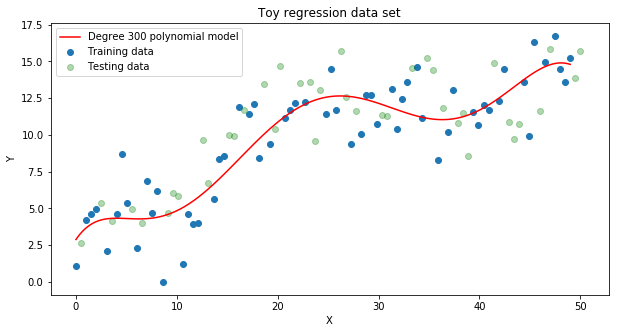

In [9]:
# use our model to predict in the range we want
X_range = np.linspace(0, 49, 500).reshape((500, 1))
y_pred = l2_simple_model.predict(X_range)

# we plot the polynomial model against the data
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.scatter(X_train, Y_train, label='Training data')
ax.scatter(X_test, Y_test, color='g', alpha=0.3, label='Testing data')
ax.plot(X_range, y_pred, color='r', label='Degree ' + str(degree) + ' polynomial model')
ax.legend(loc='best')
ax.set(xlabel='X', ylabel='Y', title='Toy regression data set')
plt.show()

In [10]:
# evaluate the model
print('Train R2:', l2_simple_model.score(X_train.reshape((X_train.shape[0], 1)), Y_train))
print('Test R2:', r2(Y_test, l2_simple_model.predict(X_test.reshape((X_test.shape[0], 1)))))

Train R2: 0.804082070711
Test R2: 0.668545190709


### L1 Regularization
$\ell_1$ regularization penalizes the the sum of the absolute values of the weights.

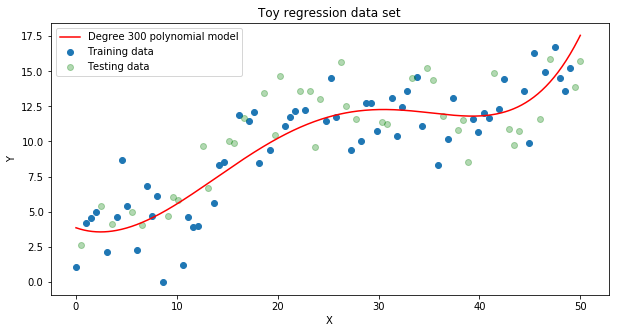

In [11]:
# add polynomial features to the data and fit a ridge regression model
l1_simple_model = make_pipeline(MinMaxScaler((0, 0.5)), PolynomialFeatures(degree), Lasso(alpha=1e-5, max_iter=100000))
l1_simple_model.fit(X_train.reshape((X_train.shape[0], 1)), Y_train)

# use our model to predict in the range we want
X_range = np.linspace(0, 50, 500).reshape((500, 1))
y_pred = l1_simple_model.predict(X_range)

# we plot the polynomial model against the data
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.scatter(X_train, Y_train, label='Training data')
ax.scatter(X_test, Y_test, color='g', alpha=0.3, label='Testing data')
ax.plot(X_range, y_pred, color='r', label='Degree ' + str(degree) + ' polynomial model')
ax.legend(loc='best')
ax.set(xlabel='X', ylabel='Y', title='Toy regression data set')
plt.show()

In [12]:
# evaluate the model
print('Train R2:', l1_simple_model.score(X_train.reshape((X_train.shape[0], 1)), Y_train))
print('Test R2:', r2(Y_test, l1_simple_model.predict(X_test.reshape((X_test.shape[0], 1)))))

Train R2: 0.771357903947
Test R2: 0.679831410943


**Question:** how does $\ell_1$ regularization differ qualitative/quantitatively form $\ell_2$ regularization? How do $\ell_1$-optimal regression weights differ from $\ell_2$-optimal regression weights? Which kind of regularization should you use for which type of application?

## C. Overfitting: MLPs

**Exercise #1:** Implement an MLP to fit the same function. Choose appropriate activation functions and hidden layer width.

In [13]:
# number of hidden nodes
H = 50
# input dimension
input_dim = 1

# create sequential multi-layer perceptron
mlp_model = Sequential()

# layer 0
mlp_model.add(Dense(H, input_dim=input_dim, 
                    activation='tanh')) 
# layer 1
mlp_model.add(Dense(H, activation='relu')) 
# layer 2
mlp_model.add(Dense(H, activation='tanh')) 

# output
mlp_model.add(Dense(1, activation='relu')) 

# configure the model
mlp_model.compile(loss='mean_squared_error', optimizer='adam')

In [14]:
# fit the model
mlp_model.fit(X_train, Y_train, batch_size=100, epochs=1000, verbose=0)

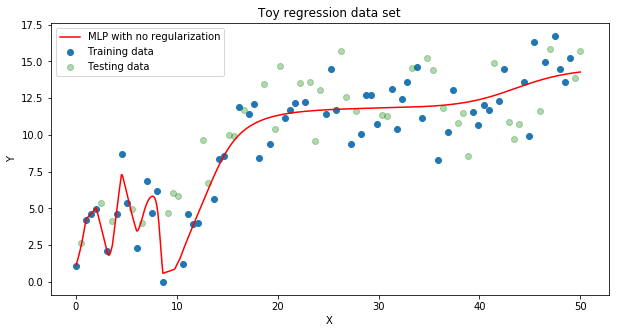

In [18]:
# use our model to predict in the range we want
X_range = np.linspace(0, 50, 500)
y_pred = mlp_model.predict(X_range)

# we plot the model against the data
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.scatter(X_train, Y_train, label='Training data')
ax.scatter(X_test, Y_test, color='g', alpha=0.3, label='Testing data')
ax.plot(X_range, y_pred, color='r', label='MLP with no regularization')
ax.legend(loc='best')
ax.set(xlabel='X', ylabel='Y', title='Toy regression data set')
plt.show()

In [19]:
# evaluate the training and testing performance of your model 
# note: you should extract check both the loss function and your evaluation metric
score = mlp_model.evaluate(X_train, Y_train, verbose=0)
print('Train loss:', score)
print('Train R2:', r2(Y_train, mlp_model.predict(X_train)))

Train loss: 2.04414575895
Train R2: 0.882584396234


In [20]:
score = mlp_model.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', score)
print('Test R2:', r2(Y_test, mlp_model.predict(X_test)))

Test loss: 5.4092042923
Test R2: 0.590977683767


## D. Regularization: MLPs

**Exercise #2:** Implement $\ell_1$ and $\ell_2$ regularized MLP to fit the same function. How does $\ell_1$ regularization differ qualitative/quantitatively form $\ell_2$ regularization? How do $\ell_1$-optimal regression weights differ from $\ell_2$-optimal regression weights? Which kind of regularization should you use for which type of application?

### L2 Regularization

In [21]:
# number of hidden nodes
H = 50
# input dimension
input_dim = 1
# regularization strength parameter
C = 9e-3

# create sequential multi-layer perceptron
mlp_model_l2 = Sequential()

# layer 0
mlp_model_l2.add(Dense(H, input_dim=input_dim, activation='tanh',
                       kernel_regularizer=regularizers.l2(C))) 
# layer 1
mlp_model_l2.add(Dense(H, activation='relu',
                       kernel_regularizer=regularizers.l2(C))) 
# layer 2
mlp_model_l2.add(Dense(H, activation='tanh',
                       kernel_regularizer=regularizers.l2(C))) 

# output
mlp_model_l2.add(Dense(1, activation='relu')) 

# configure the model
mlp_model_l2.compile(loss='mean_squared_error', optimizer='adam')

In [22]:
# fit the model
mlp_model_l2.fit(X_train, Y_train, batch_size=100, epochs=1000, verbose=0)

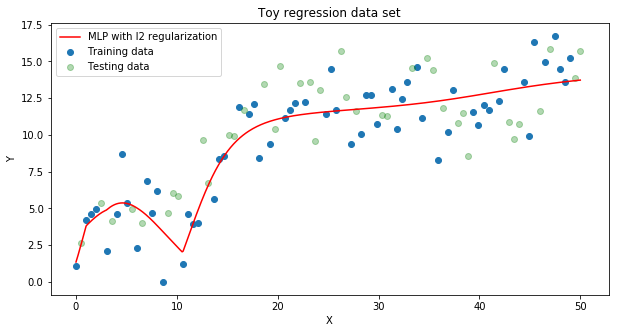

In [23]:
# use our model to predict in the range we want
X_range = np.linspace(0, 50, 500)
y_pred = mlp_model_l2.predict(X_range)

# we plot the model against the data
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.scatter(X_train, Y_train, label='Training data')
ax.scatter(X_test, Y_test, color='g', alpha=0.3, label='Testing data')
ax.plot(X_range, y_pred, color='r', label='MLP with l2 regularization')
ax.legend(loc='best')
ax.set(xlabel='X', ylabel='Y', title='Toy regression data set')
plt.show()

In [24]:
# evaluate the training and testing performance of your model 
# note: you should extract check both the loss function and your evaluation metric
score = mlp_model_l2.evaluate(X_train, Y_train, verbose=0)
print('Train loss:', score)
print('Train R2:', r2(Y_train, mlp_model_l2.predict(X_train)))

Train loss: 3.61092648506
Train R2: 0.830983013726


In [25]:
score = mlp_model_l2.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', score)
print('Test R2:', r2(Y_test, mlp_model_l2.predict(X_test)))

Test loss: 5.16914272308
Test R2: 0.659673977464


### L1 Regularization

In [26]:
# number of hidden nodes
H = 50
# input dimension
input_dim = 1
# regularization strength parameter
C = 2e-3

# create sequential multi-layer perceptron
mlp_model_l1 = Sequential()

# layer 0
mlp_model_l1.add(Dense(H, input_dim=input_dim, activation='tanh',
                       kernel_regularizer=regularizers.l1(C))) 
# layer 1
mlp_model_l1.add(Dense(H, activation='relu',
                       kernel_regularizer=regularizers.l1(C))) 
# layer 2
mlp_model_l1.add(Dense(H, activation='tanh',
                       kernel_regularizer=regularizers.l1(C))) 

# output
mlp_model_l1.add(Dense(1, activation='relu')) 

# configure the model
mlp_model_l1.compile(loss='mean_squared_error', optimizer='adam')

In [27]:
# fit the model
mlp_model_l1.fit(X_train, Y_train, batch_size=100, epochs=1000, verbose=0)

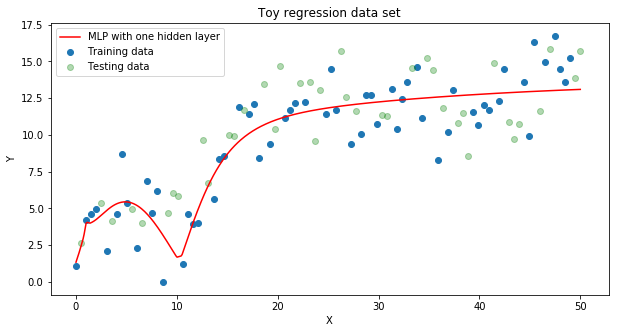

In [28]:
# use our model to predict in the range we want
X_range = np.linspace(0, 50, 500)
y_pred = mlp_model_l1.predict(X_range)

# we plot the model against the data
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.scatter(X_train, Y_train, label='Training data')
ax.scatter(X_test, Y_test, color='g', alpha=0.3, label='Testing data')
ax.plot(X_range, y_pred, color='r', label='MLP with l1 regularization')
ax.legend(loc='best')
ax.set(xlabel='X', ylabel='Y', title='Toy regression data set')
plt.show()

In [29]:
# evaluate the training and testing performance of your model 
# note: you should extract check both the loss function and your evaluation metric
score = mlp_model_l1.evaluate(X_train, Y_train, verbose=0)
print('Train loss:', score)
print('Train R2:', r2(Y_train, mlp_model_l1.predict(X_train)))

Train loss: 3.78805012703
Train R2: 0.818897751228


In [30]:
score = mlp_model_l1.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', score)
print('Test R2:', r2(Y_test, mlp_model_l1.predict(X_test)))

Test loss: 5.36293735504
Test R2: 0.642503873081


### Drop Out
"Dropout is a regularization technique for neural network models proposed by Srivastava, et al. in their 2014 paper Dropout: A Simple Way to Prevent Neural Networks from Overfitting.

Dropout is a technique where randomly selected neurons are ignored during training. They are “dropped-out” randomly. This means that their contribution to the activation of downstream neurons is temporally removed on the forward pass and any weight updates are not applied to the neuron on the backward pass.

As a neural network learns, neuron weights settle into their context within the network. Weights of neurons are tuned for specific features providing some specialization. Neighboring neurons become to rely on this specialization, which if taken too far can result in a fragile model too specialized to the training data. This reliant on context for a neuron during training is referred to complex co-adaptations.

You can imagine that if neurons are randomly dropped out of the network during training, that other neurons will have to step in and handle the representation required to make predictions for the missing neurons. This is believed to result in multiple independent internal representations being learned by the network.

The effect is that the network becomes less sensitive to the specific weights of neurons. This in turn results in a network that is capable of better generalization and is less likely to overfit the training data."

**Exercise #3:** Implement an MPL with drop out after each hidden layer to fit the same function. How does dropout regularization differ qualitative/quantitatively from $\ell_1$ or $\ell_2$ regularization? Which kind of regularization should you use for which type of application?

In [31]:
# number of hidden nodes
H = 50
# input dimension
input_dim = 1
# dropout rate
d = 0.2

# create sequential multi-layer perceptron
mlp_model_drop = Sequential()

# layer 0
mlp_model_drop.add(Dense(H, input_dim=input_dim, activation='tanh')) 
# drop out layer
mlp_model_drop.add(Dropout(d))
# layer 1
mlp_model_drop.add(Dense(H, activation='relu')) 
# drop out layer
mlp_model_drop.add(Dropout(d))
# layer 2
mlp_model_drop.add(Dense(H, activation='tanh')) 
# drop out layer
mlp_model_drop.add(Dropout(d))

# output
mlp_model_drop.add(Dense(1, activation='relu')) 

# configure the model
mlp_model_drop.compile(loss='mean_squared_error', optimizer='adam')

In [32]:
# fit the model
mlp_model_drop.fit(X_train, Y_train, batch_size=100, epochs=1000, verbose=0)

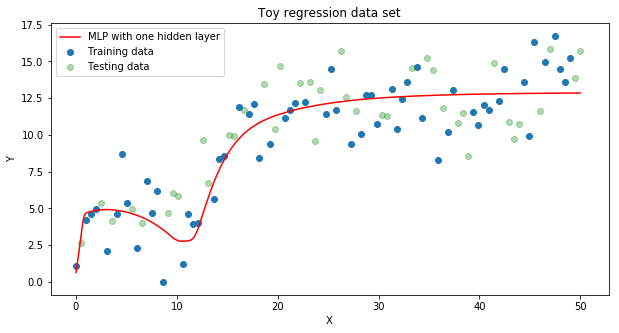

In [33]:
# use our model to predict in the range we want
X_range = np.linspace(0, 50, 500)
y_pred = mlp_model_drop.predict(X_range)

# we plot the model against the data
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.scatter(X_train, Y_train, label='Training data')
ax.scatter(X_test, Y_test, color='g', alpha=0.3, label='Testing data')
ax.plot(X_range, y_pred, color='r', label='MLP with drop out')
ax.legend(loc='best')
ax.set(xlabel='X', ylabel='Y', title='Toy regression data set')
plt.show()

In [34]:
# evaluate the training and testing performance of your model 
# note: you should extract check both the loss function and your evaluation metric
score = mlp_model_drop.evaluate(X_train, Y_train, verbose=0)
print('Train loss:', score)
print('Train R2:', r2(Y_train, mlp_model_drop.predict(X_train)))

Train loss: 3.38904803594
Train R2: 0.805333284228


In [35]:
score = mlp_model_drop.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', score)
print('Test R2:', r2(Y_test, mlp_model_drop.predict(X_test)))

Test loss: 4.38192601204
Test R2: 0.66865633698


## II. Working with Image Data: CNNs

Often in machine learning applications involving images (such as image classification, automatic image captioning, object dection, recognition or scene labeling) the first task is to parse an image into a set of 'features' that are relevant for the task at hand. That is, we prefer not to work with images as a set of pixels. **Question:** can you think of some reasons for why this is? Traditionally, the set of relevant features to extract from raw images need to be defined before hand using domain expertise and then must be 'engineered' (computed) from the images represented as pixels. For example, for training a model to distinguish a night scene from a day scene, one might want to compare the color histograms of two images. The problem with the approach of feature engineering is that, a priori, it can be difficult to know what type of features best facilitate the performance of a given task, furthermore, the features one has engineered to optimize one task may not generalize to help accomplish another.

Neural networks provide a natural and flexible framework for extracting useful features from raw images. Recall from the previous lab that, often, while training a NN to accomplish a particular task (like classification) we get, from this process, a useful alternate representaiton of the data. Taking this intuition further, we ask whether or not we can use a neural network to automatically extract useful features (or alternate representations) from the data by optimizing the network for a particular task.

In this section, we will consider a particular type of neural network, the convolutional network (CNN), that is especially suited for feature extraction of image data. A CNN is a neural network typically composed of two components, one component for extracting useful features of the data, and another for performing a ML task (like classification based on the featurized data:

<img src="./cnn.png" style="width: 700px;" align="center"/>

The feature extracting layers are called **convolutional layers**, each node in these layers uses a small fixed set of weights to transform the image in the following way:

<img src="./convolution_layer.gif" style="width: 600px;" align="center"/>

This set of fixed weights for each node in the convolutional layer is often called a ***filter*** or a ***kernel***. The term "filter" comes from image processing where one has standard ways to transforms raw images:
<img src="./filter.png" style="width: 600px;" align="center"/>

Often in CNN's we include a **pooling layer** after a convolutional layer. In a pooling layer, we 'condense' small regions in the convolved image:

<img src="./pool_layer.gif" style="width: 600px;" align="center"/>

In [36]:
# image shape
image_shape = (64, 64)

# load faces data
faces_dataset = fetch_olivetti_faces(shuffle=True, random_state=random_seed)
faces = faces_dataset.data
n_samples, n_features = faces.shape

# function to visualize images
def plot_face(ax, img, image_shape):
    vmax = max(img.max(), -img.min())
    ax.imshow(img.reshape(image_shape), cmap=plt.cm.gray,
              interpolation='nearest',
              vmin=-vmax, vmax=vmax)
    return ax

In [37]:
labels = faces_dataset.target
# take images from only two individuals
X_flat = faces[(labels == 0) | (labels == 1)]
X = X_flat.reshape((20, 64, 64, 1))
Y = labels[(labels == 0) | (labels == 1)]

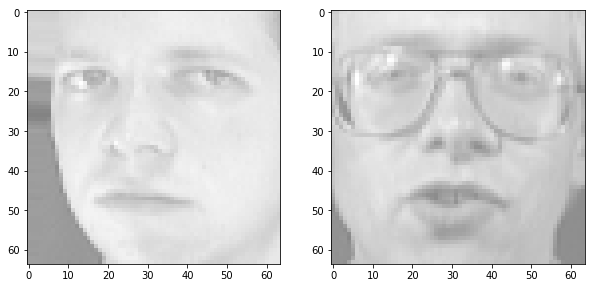

In [38]:
# we plot two sample images from the data set
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0] = plot_face(ax[0], X[Y == 0][0], image_shape)
ax[1] = plot_face(ax[1], X[Y == 1][0], image_shape)
plt.show()

## A. Classification with a MLP

**Exercise #4:** Build a shallow MLP to classify the face images. What are some theoretical strengths and drawbacks of using very wide networks (with large number of hidden nodes in each layer) versus very narrow networks? ***Hint:*** think about how image data is represented as input.

In [39]:
# fix a width that is suited for visualizing the output of hidden layers
H = input_dim
input_dim = X_flat.shape[1]

# create sequential multi-layer perceptron
model = Sequential()
#layer 0
model.add(Dense(H, input_dim=input_dim, activation='tanh')) 
#layer 1
model.add(Dense(H, activation='tanh'))
#binary classification, one output
model.add(Dense(1, activation='sigmoid')) 

# configure the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [40]:
# fit the model
model.fit(X_flat, Y, batch_size=20, epochs=10, verbose=0)

In [41]:
# evaluate the training and testing performance of your model 
# note: you should extract check both the loss function and your evaluation metric
score = model.evaluate(X_flat, Y, verbose=0)
print('Train loss:', score[0])
print('Train accuracy:', score[1])

Train loss: 0.544191479683
Train accuracy: 0.949999988079


## B. Classification with a CNN

**Exercise #5:** Build a CNN with one convolutional layer and one pooling layer to classify the face images. What are some theoretical strengths and drawbacks of using CNN versus MLP for handling image data? 

In [42]:
# kernel size
kernel_size = (8, 8)
stride_size = (1, 1)
filters = 2

cnn_model = Sequential()
# feature extraction layer 0: convolution
cnn_model.add(Conv2D(filters, kernel_size=kernel_size, strides=stride_size,
                 activation='relu',
                 input_shape=(64, 64, 1)))
# feature extraction layer 1: max pooling
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
# classification layer 2: flattening
cnn_model.add(Flatten())
# classification layer 3: dense non-linear transformation
cnn_model.add(Dense(100, activation='relu'))
# classification layer 4: output label probability
cnn_model.add(Dense(1, activation='sigmoid'))

cnn_model.compile(loss='binary_crossentropy',
                  optimizer=keras.optimizers.SGD(lr=0.01),
                  metrics=['accuracy'])

In [43]:
# fit the model
cnn_model.fit(X, Y, batch_size=20, epochs=500, verbose=0)

In [44]:
# evaluate the training and testing performance of your model 
# note: you should extract check both the loss function and your evaluation metric
score = cnn_model.evaluate(X, Y, verbose=0)
print('Train loss:', score[0])
print('Train accuracy:', score[1])

Train loss: 0.00539885740727
Train accuracy: 1.0


## C. What Exactly Does a BNN Learn?

In the last lab, we saw that an MLP trained for classification learns a non-linear transformation of the data so that the classes are linearly separable. We visualized the outputs of the hidden layers to observe the sequential transformation of the data. Now we want to get an intuitive understanding of what each hidden layer in a CNN is doing to the data.

**Exercise #6:** visualize the weights connected the input image to each node in the convolutional layer, these are called 'filters'. Explain how each filter is applied to the input image.

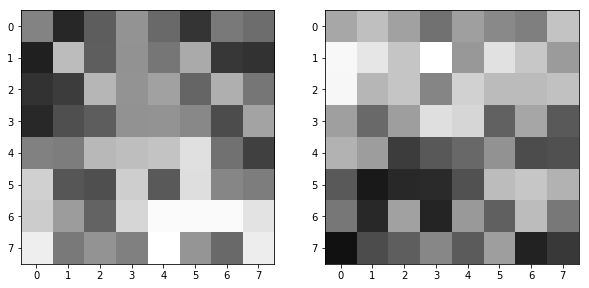

In [46]:
# we visualize the two filters we learned
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0] = plot_face(ax[0], cnn_model.layers[0][:, :, :, 0].flatten(), (8, 8))
ax[1] = plot_face(ax[1], cnn_model.layers[0][:, :, :, 1].flatten(), (8, 8))
plt.show()

**Exercise #7:** visualize the output of the convolutional layer and the pooling layer separately. Describe how each layer has transformed the data.

In [47]:
# define a network with one layer - a convolutional layer
# with the weights from the first layer of the CNN you learned above
latent_features = Sequential()
latent_features.add(Conv2D(2, kernel_size=kernel_size, strides=stride_size, weights=cnn_model.layers[0].get_weights(),
                 activation='relu',
                 input_shape=(64, 64, 1)))

activations = latent_features.predict(X)

In [48]:
activations.shape

(20, 57, 57, 2)

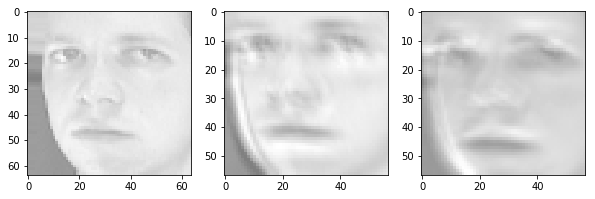

In [49]:
# visualize a training image after it passes through each filter
fig, ax = plt.subplots(1, 3, figsize=(10, 5))
ax[0] = plot_face(ax[0], X[Y == 0][0], image_shape)
ax[1] = plot_face(ax[1], activations[Y == 0][0][:, :, 0], (57, 57))
ax[2] = plot_face(ax[2], activations[Y == 0][0][:, :, 1], (57, 57))
plt.show()